<a href="https://colab.research.google.com/github/AbhishekMShastryK/EmotionAnalysis/blob/main/Emotion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth',-1)
import seaborn as sb
sb.set(style='darkgrid')
sb.set(font_scale=1.3)
import numpy as np
np.random.seed(37)
import matplotlib.pyplot as pt

import os
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
!pip install emoji
import emoji
from sklearn.base import BaseEstimator, TransformerMixin
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
import collections
from time import time
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import gensim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


     |████████████████████████████████| 184 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=9354126d24f1f465cf69bf0b5139578616f3b10cdc40f10b8a0d60f74aefd570
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/My Drive/text_emotion.txt',sep=';')
df.head()

,content,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger


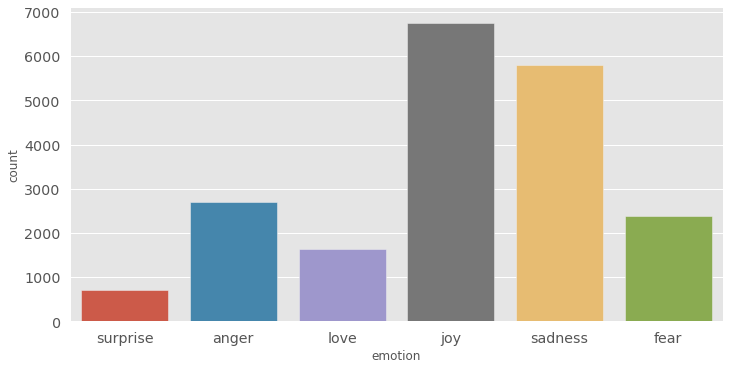

In [4]:
df = df.reindex(np.random.permutation(df.index))
with pt.style.context('ggplot'):
  sb.catplot(x = 'emotion',data = df,kind = 'count',height = 5,aspect = 2)
  pt.show()

In [ ]:
class CleanText(BaseEstimator, TransformerMixin):
  def remove_mentions(self, input_text):
    return re.sub(r'/@\w+\s*/','',input_text)

  def remove_hash(self, input_text):
    return re.sub(r'/#\w+\s*/','',input_text)

  def remove_urls(self, input_text):
    return re.sub(r'http.?://[^\s]+[\s]?','',input_text)

  def emoji_oneword(self, input_text):
    return input_text.replace('_','')

  def remove_punctuation(self, input_text):
    punc = string.punctuation
    trantab = str.maketrans(punc, len(punc)*' ')
    return input_text.translate(trantab)

  def remove_digits(self, input_text):
    return re.sub('\d+','',input_text)

  def to_lower(self, input_text):
    return input_text.lower()

  def remove_stopwords(self, input_text):
    stopwords_list = stopwords.words('english')
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list and len(word) > 2)]
    return " ".join(clean_words)

  def stemming(self, input_text):
    porter = PorterStemmer()
    words = input_text.split()
    stemmed_words = [porter.stem(word) for word in words]
    return " ".join(stemmed_words)

  def fit(self, X, Y = None, **fit_params):
    return self

  def transform(self, X, **transform_params):
    clean_X = X.apply(self.remove_mentions).apply(self.remove_hash).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
    return clean_X

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
ct = CleanText()
sr_clean = ct.fit_transform(df.content)

empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[No_text]'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
0 records have no words left after text cleaning


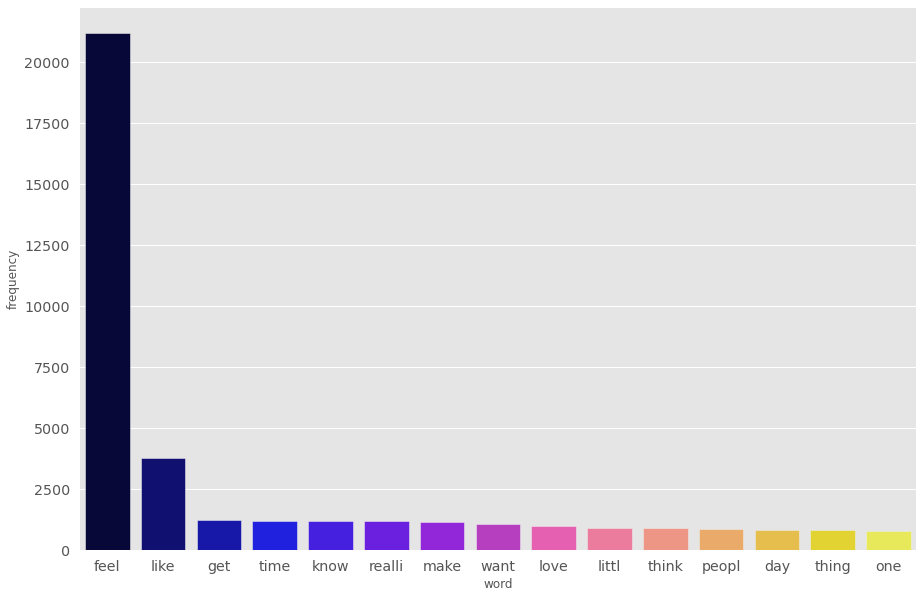

In [ ]:
cv = CountVectorizer()
clm = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(),np.asarray(clm.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(15), columns = ['word','frequency'])
with pt.style.context('ggplot'):
  fig, ax = pt.subplots(figsize = (15,10))
  sb.barplot(x = 'word', y = 'frequency', data = word_counter_df, palette = 'gnuplot2', ax=ax)
  pt.show()

In [ ]:
def grid_vect(clf,parameters_clf,X_train,X_test,parameters_text = None,vect = None, is_w2v = False):
  textcountscolumns = ['capital_word_count', 
                       'emoji_count', 
                       'punctuation_count', 
                       'hashtag_count', 
                       'mention_count', 
                       'url_count', 
                       'word_count']
  if is_w2v:
    w2vcols = []
    for i in (SIZE):
      w2vcols.append(i)
    features = FeatureUnion([('textcounts', ColumnExtractor(cols = textcountscolumns)), 
                             ('w2v', ColumnExtractor(cols = w2vcols))],
                             n_jobs = -1)
  else:
    features = FeatureUnion([('textcounts', ColumnExtractor(cols = textcountscolumns)), 
                             ('pipe', Pipeline([('cleantext', ColumnExtractor(cols = 'clean_text')), ('vect',vect)]))],
                             n_jobs = -1)
  pipeline = Pipeline([('features',features), ('clf',clf)])
  parameters = dict()
  if parameters_text:
    parameters.update(parameters_text)
  parameters.update(parameters_clf)
  grid_search = GridSearchCV(pipeline,parameters,n_jobs = -1,verbose = 1,cv = 5)
  print("Performing grid search...")
  print("Pipeline:", [name for name,_ in pipeline.steps])
  print("Parameters:")
  pprint(parameters)
  t0 = time()
  grid_search.fit(X_train,Y_train)
  print("Done in %.3fs" % (time()-t0))
  print()
  print("Best cv score %.3f" %grid_search.best_score_)
  print("Best parameter set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
  print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test,Y_test))
  print("\n")
  print("Classification Report Test Data")
  print(classification_report(Y_test,grid_search.best_estimator_.predict(X_test)))
  return grid_search

In [ ]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
  def __init__(self,cols):
    self.cols = cols
  def transform(self, X, **transform_params):
    return X[self.cols]
  def fit(self, X, Y=None, **fit_params):
    return self

In [ ]:
class TextCounts(BaseEstimator, TransformerMixin):
  def count_regex(self, pattern, tweet):
    return len(re.findall(pattern, tweet))
  def fit(self, X, Y=None, **fit_params):
    return self
  def transform(self, X, **transform_params):
    word_count = X.apply(lambda x: self.count_regex(r'\w+',x))
    mention_count = X.apply(lambda x:self.count_regex(r'@\w+',x))
    hashtag_count = X.apply(lambda x:self.count_regex(r'#\w+',x))
    capital_word_count = X.apply(lambda x:self.count_regex(r'\b[A-Z][2,]\b',x))
    punctuation_count = X.apply(lambda x:self.count_regex(r'!|\?',x))
    url_count = X.apply(lambda x:self.count_regex(r'http.?//[^\s][\s]?',x))
    emoji_count = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:',x))

    df = pd.DataFrame({'word_count':word_count, 
                    'mention_count':mention_count, 
                    'hashtag_count':hashtag_count, 
                    'capital_word_count':capital_word_count, 
                    'punctuation_count':punctuation_count, 
                    'url_count':url_count, 
                    'emoji_count':emoji_count})
    
    return df
tc = TextCounts()
df_tc = tc.fit_transform(df.content)
df_tc['emotion'] = df.emotion

In [ ]:
parameters_vect = {'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
                   'features__pipe__vect__ngram_range': ((1,1),(1,2)),
                   'features__pipe__vect__min_df': (1,2)}
parameters_mnb = {'clf__alpha': (0.25, 0.5, 0.75)}
parameters_logreg = {'clf__C': (0.25, 0.5, 0.75),
                     'clf__penalty': ('l1','l2')}

In [ ]:
df_model = df_tc
df_model['clean_text'] = sr_clean
df_model.columns.tolist()
X_train, X_test, Y_train, Y_test = train_test_split(df_model.drop('emotion', axis=1), df_model.emotion, test_size = 0.1, random_state = 37)
mnb = MultinomialNB()
logreg = LogisticRegression()
countvect = CountVectorizer()
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text = parameters_vect, vect = countvect)
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text = parameters_vect, vect = countvect)

In [ ]:
tfidfvect = TfidfVectorizer()
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text = parameters_vect, vect = tfidfvect)
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text = parameters_vect, vect = tfidfvect)

Performing grid search...
Pipeline: ['features', 'clf']
Parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.4min finished


Done in 86.659s

Best cv score 0.761
Best parameter set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.769


Classification Report Test Data
              precision    recall  f1-score   support

       anger       0.96      0.61      0.74       253
        fear       0.88      0.58      0.70       220
         joy       0.70      0.97      0.81       712
        love       0.93      0.25      0.39       165
     sadness       0.79      0.89      0.84       588
    surprise       1.00      0.10      0.18        62

    accuracy                           0.77      2000
   macro avg       0.88      0.56      0.61      2000
weighted avg       0.81      0.77      0.74      2000

Performing grid search...
Pipeline: ['features', 'clf']
Parameters:
{'clf__C': (0.25, 0.5, 0.75),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 13.4min finished


Done in 808.309s

Best cv score 0.727
Best parameter set:
	clf__C: 0.75
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.722


Classification Report Test Data
              precision    recall  f1-score   support

       anger       0.90      0.46      0.61       253
        fear       0.78      0.55      0.65       220
         joy       0.71      0.92      0.80       712
        love       0.74      0.36      0.49       165
     sadness       0.74      0.83      0.78       588
    surprise       0.04      0.03      0.04        62

    accuracy                           0.72      2000
   macro avg       0.65      0.53      0.56      2000
weighted avg       0.73      0.72      0.70      2000



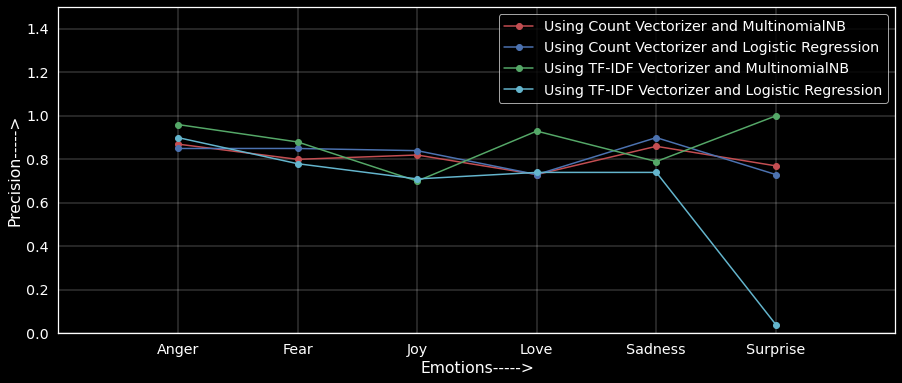

In [ ]:
with pt.style.context('dark_background'):
  p1 = [0.87,0.80,0.82,0.73,0.86,0.77]
  p2 = [0.85,0.85,0.84,0.73,0.90,0.73]
  p3 = [0.96,0.88,0.70,0.93,0.79,1.00]
  p4 = [0.90,0.78,0.71,0.74,0.74,0.04]
  x = [1, 2, 3, 4, 5, 6]
  pt.rcParams["figure.figsize"] = (15, 6)
  pt.plot(x, p1, marker='o', color='r',label = 'Using Count Vectorizer and MultinomialNB')
  pt.legend()
  pt.plot(x, p2, marker='o', color='b',label = 'Using Count Vectorizer and Logistic Regression')
  pt.legend()
  pt.plot(x, p3, marker='o', color='g',label = 'Using TF-IDF Vectorizer and MultinomialNB')
  pt.legend()
  pt.plot(x, p4, marker='o', color='c',label = 'Using TF-IDF Vectorizer and Logistic Regression')
  pt.legend()
  pt.axis([0, 7, 0, 1.5])
  my_xticks = ['Anger','Fear','Joy','Love','Sadness','Surprise']
  pt.xticks(x, my_xticks)
  pt.grid(color='w', linestyle='-', linewidth=0.3)
  pt.xlabel('Emotions----->')
  pt.ylabel('Precision----->')

  pt.show()

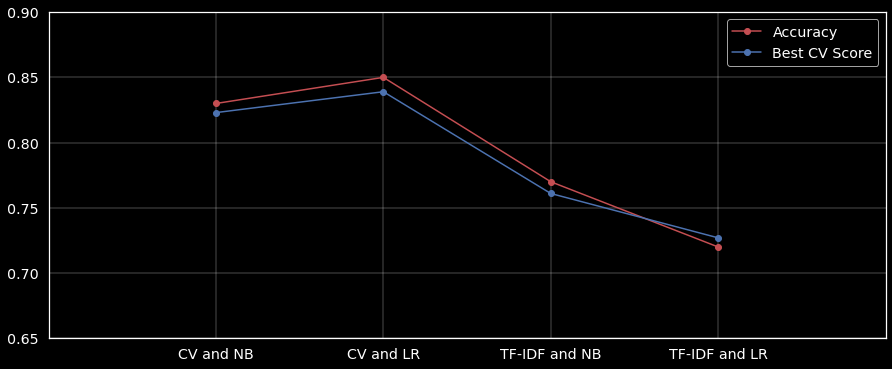

In [ ]:
with pt.style.context('dark_background'):
  acc = [0.83,0.85,0.77,0.72]
  cv_s = [0.823,0.839,0.761,0.727]
  x = [1,2,3,4]
  pt.rcParams["figure.figsize"] = (15, 6)
  pt.plot(x, acc, marker='o', color='r',label = 'Accuracy')
  pt.legend()
  pt.plot(x, cv_s, marker='o', color='b',label = 'Best CV Score')
  pt.legend()
  pt.axis([0, 5, 0.65, 0.9])
  my_xticks = ['CV and NB','CV and LR','TF-IDF and NB','TF-IDF and LR']
  pt.xticks(x, my_xticks)
  pt.grid(color='w', linestyle='-', linewidth=0.3)
  pt.show()